In [1]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
import sys

sys.path.append("/home/cctrotte/krauthammer/eustar_clean/benchmark_VAE/")
sys.path.append("/home/cctrotte/krauthammer/eustar_clean/benchmark_VAE/src/")
import os
import pickle
from pythae.models import AutoModel
from pythae.ssc.plots import *
import random
import matplotlib.pyplot as plt
import numpy as np
from pythae.ssc.results import EvalPatient, EvaluationDataset
from pythae.ssc.utils import load_cv, remove_short_samples

In [2]:
# adapt paths
data_path = "/home/cctrotte/krauthammer/eustar_clean/fake_data/processed/"
figure_path = "/home/cctrotte/krauthammer/eustar_clean/demo_notebooks/plots/"
model_path = "/home/cctrotte/krauthammer/eustar_clean/demo_notebooks/saved_models/model_fold_0/"

name = "_ml4h"
with open(data_path + "bodies_" + name + ".pkl", "rb") as file:
    bodies = pickle.load(file)
with open(data_path + "cohorts_" + name + ".pkl", "rb") as file:
    cohorts = pickle.load(file)

In [3]:
# variables info
var_weights0 = [
    var.class_weight_norm for var in (bodies[0].variables + bodies[0].labels)
]
(
    data_train_folds,
    data_valid_folds,
    data_test_folds,
    varNames,
    varSplits,
    xyt0,
    xyt1,
) = load_cv(data_path, n_folds = 2, name=name)
var_names0 = [var.name for var in (bodies[0].variables + bodies[0].labels)]

names_x0 = [vN for i, vN in enumerate(var_names0) if xyt0[i] == "x"]
names_y0 = [vN for i, vN in enumerate(var_names0) if xyt0[i] == "y"]
names_s0 = [vN for i, vN in enumerate(var_names0) if xyt0[i] == "s"]

kinds_x0 = [
    var.kind
    for var in (bodies[0].variables + bodies[0].labels)
    for nx in names_x0
    if var.name == nx
]
kinds_y0 = [
    var.kind
    for var in (bodies[0].variables + bodies[0].labels)
    for nx in names_y0
    if var.name == nx
]
splits_x0 = [vN for i, vN in enumerate(varSplits) if xyt0[i] == "x"]
splits_y0 = [vN for i, vN in enumerate(varSplits) if xyt0[i] == "y"]
splits_s0 = [vN for i, vN in enumerate(varSplits) if xyt0[i] == "s"]

names_x1 = [vN for i, vN in enumerate(varNames) if xyt1[i] == "x"]
kinds_x1 = [item for i, spl in enumerate(splits_x0) for item in [kinds_x0[i]] * spl]

In [4]:
# remove samples of length 0 or 1
for i, (data_train, data_valid, data_test) in enumerate(
    zip(data_train_folds, data_valid_folds, data_test_folds)
):
    data_train, data_valid, data_test = remove_short_samples(
        data_train, data_valid, data_test
    )

    data_train_folds[i] = data_train
    data_valid_folds[i] = data_valid
    data_test_folds[i] = data_test

In [5]:

last_training = sorted(os.listdir(model_path))[-1]
model = AutoModel.load_from_folder(os.path.join(model_path, last_training, 'final_model'))


In [6]:
# move to cpu
model.cpu()
model.device = "cpu"
model.classifiers = [classif.cpu() for classif in model.classifiers]
model.encoder.device = "cpu"
model.decoder.device = "cpu"
fold = 0
data_train = data_train_folds[fold]
data_valid = data_valid_folds[fold]
data_test = data_test_folds[fold]
body = bodies[fold]

In [7]:
from openTSNE import TSNE

In [8]:
tsne = TSNE(
    perplexity=70,
    metric="euclidean",
    n_jobs=8,
    random_state=42,
    verbose=True,
)

In [9]:
evaluation = EvaluationDataset(
    data_test,
    model,
    body,
    splits_x0,
    names_x0,
    kinds_x0,
    splits_y0,
    names_y0,
    kinds_y0,
    names_s0,
    kinds_x1,
    names_x1,
    len(data_test),
)
evaluation.evaluate(num_samples=10)

In [10]:
# fit on train
sample_batch_train = data_train.get_ith_sample_batch_with_customDataLoader(0, 1400)
out_train = model(sample_batch_train)

In [11]:
splits_train = sample_batch_train["splits"]
indices_recon_train = torch.cat(
    [
        torch.cat(
            [
                torch.cat(
                    [
                        torch.full((index, 1), True),
                        torch.full((splits_train[pat] - index, 1), False),
                    ],
                    dim=0,
                )
                for index in range(0, splits_train[pat] + 1)
            ]
        )
        for pat in range(len(splits_train))
    ]
).flatten()
# fit only on reconstruction indices
z_tsne_train = tsne.fit(out_train.z[indices_recon_train].detach())

--------------------------------------------------------------------------------
TSNE(early_exaggeration=12, n_jobs=8, perplexity=70, random_state=42,
     verbose=True)
--------------------------------------------------------------------------------
===> Finding 210 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 6.67 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.59 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.11 seconds
===> Running optimization with exaggeration=12.00, lr=2634.42 for 250 iterations...
Iteration   50, KL divergence 5.5011, 50 iterations in 1.4994 sec
Iteration  100, KL divergence 5.4905, 50 iterations in 1.3428 sec
Iteration  150, KL divergence 5.4902, 50 iterations in 1.4093 sec
Iteration  200, KL divergence 5.4902, 50 iterations in 1.4607 sec
Iteration  250, KL divergence 5.4902, 50 iterations in 1.2616 sec
   --> Time elapsed: 6.98 seconds
===> Running optimizatio

In [12]:
z_tsne_test = z_tsne_train.transform(
    evaluation.predictions.z[evaluation.indices_recon].detach()
)

===> Finding 15 nearest neighbors in existing embedding using Annoy approximate search...
   --> Time elapsed: 6.27 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.01 seconds
===> Running optimization with exaggeration=4.00, lr=0.10 for 0 iterations...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=1.50, lr=0.10 for 250 iterations...
Iteration   50, KL divergence 173464.0794, 50 iterations in 0.1944 sec
Iteration  100, KL divergence 172159.5964, 50 iterations in 0.2107 sec
Iteration  150, KL divergence 171311.6359, 50 iterations in 0.2068 sec
Iteration  200, KL divergence 170722.8219, 50 iterations in 0.2096 sec
Iteration  250, KL divergence 170265.0547, 50 iterations in 0.2085 sec
   --> Time elapsed: 1.03 seconds


In [13]:
list_of_arrays_recon = np.split(
    evaluation.non_missing_y_recon[evaluation.indices_recon],
    np.cumsum(evaluation.splits_y0[:-1]),
    axis=1,
)

In [14]:
from tslearn.utils import to_time_series_dataset
from tslearn.clustering import TimeSeriesKMeans

In [15]:
metric = "dtw"

In [16]:
indices_recon_train_full = torch.cat(
    [
        torch.cat(
            [
                torch.cat(
                    [
                        torch.full((index, 1), True),
                        torch.full((splits_train[pat] - index, 1), False),
                    ],
                    dim=0,
                )
                for index in range(0, splits_train[pat] + 1)
            ]
        )
        for pat in range(len(splits_train))
    ]
).flatten()
DATA_train = torch.split(out_train.z, [elem * (elem + 1) for elem in splits_train])
DATA_train = [
    torch.split(elem, [splits_train[index]] * (splits_train[index] + 1))
    for index, elem in enumerate(DATA_train)
]
DATA_train_splitted = [elem[-1] for elem in DATA_train]
DATA_train = torch.cat(DATA_train_splitted)
DATA_train_ts = torch.split(DATA_train, splits_train, dim=0)
DATA_train_ts = [elem.detach().numpy() for elem in DATA_train_ts]
DATA_train_ts = to_time_series_dataset(DATA_train_ts)

In [17]:
DATA_test = torch.split(
    evaluation.predictions.z, [elem * (elem + 1) for elem in evaluation.splits]
)
DATA_test = [
    torch.split(elem, [evaluation.splits[index]] * (evaluation.splits[index] + 1))
    for index, elem in enumerate(DATA_test)
]
DATA_test = torch.cat([elem[-1] for elem in DATA_test])
DATA_test_ts = torch.split(DATA_test, evaluation.splits, dim=0)
DATA_test_ts = [elem.detach().numpy() for elem in DATA_test_ts]
DATA_test_ts = to_time_series_dataset(DATA_test_ts)

In [18]:
model_KM = TimeSeriesKMeans(
    n_clusters=3, metric=metric, max_iter=30, random_state=0, n_jobs=-1
)
model_KM.fit(DATA_train_ts)
clusters_train = model_KM.predict(DATA_train_ts)

In [19]:
z_means1 = model_KM.cluster_centers_
embedding_means1 = z_tsne_train.transform(
    z_means1.reshape(-1, model_KM.cluster_centers_.shape[-1])
)

===> Finding 15 nearest neighbors in existing embedding using Annoy approximate search...
   --> Time elapsed: 0.01 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=4.00, lr=0.10 for 0 iterations...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=1.50, lr=0.10 for 250 iterations...
Iteration   50, KL divergence 406.1981, 50 iterations in 0.8681 sec
Iteration  100, KL divergence 400.0670, 50 iterations in 0.9129 sec
Iteration  150, KL divergence 395.9459, 50 iterations in 1.1108 sec
Iteration  200, KL divergence 392.0163, 50 iterations in 1.0066 sec
Iteration  250, KL divergence 388.7419, 50 iterations in 1.0831 sec
   --> Time elapsed: 4.98 seconds


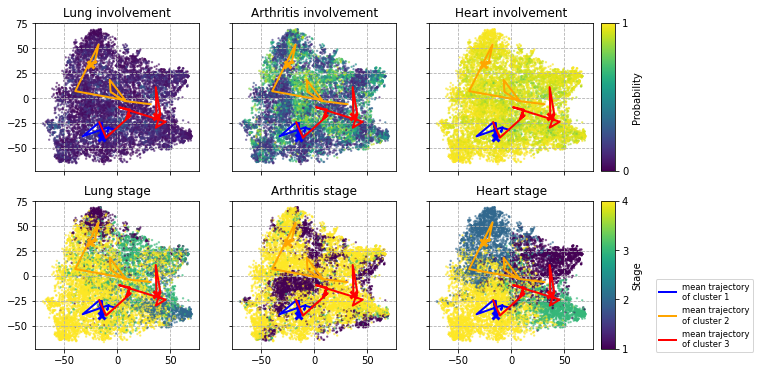

In [20]:
import matplotlib.cm as cm

titles = {
    0: "Lung involvement",
    4: "Arthritis involvement",
    2: "Heart involvement",
    1: "Lung stage",
    5: "Arthritis stage",
    3: "Heart stage",
}
cluster_colors = ["blue", "orange", "red"]
fig, axs = plt.subplots(2, 3, figsize=(10, 6), sharex=True, sharey=True)


for j, (label_index, title) in enumerate(titles.items()):
    row = j // 3  # Calculate the row index
    col = j % 3  # Calculate the column index
    ax = axs[row, col]

    if title in ["Lung involvement", "Heart involvement", "Arthritis involvement"]:
        overlay_color = evaluation.res_list_y[label_index][1].detach()
        colorbar_vmin = 0
        colorbar_vmax = 1
        color = overlay_color[evaluation.indices_recon]
        name_cbar = "Probability"
    else:
        overlay_color = evaluation.predicted_cats_y
        colorbar_vmin = np.nanmin(
            np.array(overlay_color[evaluation.indices_recon][:, label_index])
        )
        colorbar_vmax = np.nanmax(
            np.array(overlay_color[evaluation.indices_recon][:, label_index])
        )
        color = overlay_color[evaluation.indices_recon][:, label_index]
        name_cbar = "Stage"

    scatter = ax.scatter(
        z_tsne_test[:, 0],
        z_tsne_test[:, 1],
        c=color,
        alpha=0.5,
        vmin=colorbar_vmin,
        vmax=colorbar_vmax,
        s=2,
    )
    for c_index, (i_1, i_2) in enumerate([(28, 42), (0, 14), (14, 28)]):
        ax.plot(
            embedding_means1[i_1:i_2][0, 0],
            embedding_means1[i_1:i_2][0, 1],
            marker="x",
            markersize=7,
            markeredgewidth=3,
            color=cluster_colors[c_index],
        )

        ax.plot(
            embedding_means1[i_1:i_2][:, 0],
            embedding_means1[i_1:i_2][:, 1],
            label=f"mean trajectory\nof cluster {c_index + 1}",
            color=cluster_colors[c_index],
            linewidth=2,
        )

    ax.set_title(titles[label_index])

    ax.grid(linestyle="--")

    if (row == 1) & (col == 2):
        sm = cm.ScalarMappable(
            cmap=scatter.get_cmap(),
            norm=plt.Normalize(vmin=colorbar_vmin, vmax=colorbar_vmax),
        )
        sm.set_array([])  # Set an empty array to ensure correct color mapping
        cbar_ax = fig.add_axes(
            [
                axs[1, 2].get_position().x1 + 0.01,
                axs[1, 2].get_position().y0,
                0.02,
                axs[1, 2].get_position().height,
            ]
        )
        cbar_ax = fig.colorbar(
            sm, cax=cbar_ax, fraction=0.046, pad=0.04, ticks=[1, 2, 3, 4]
        )
        cbar_ax.ax.set_ylabel("Stage")
    if (row == 0) & (col == 2):
        sm = cm.ScalarMappable(
            cmap=scatter.get_cmap(),
            norm=plt.Normalize(vmin=colorbar_vmin, vmax=colorbar_vmax),
        )
        sm.set_array([])  # Set an empty array to ensure correct color mapping
        cbar_ax = fig.add_axes(
            [
                axs[0, 2].get_position().x1 + 0.01,
                axs[0, 2].get_position().y0,
                0.02,
                axs[0, 2].get_position().height,
            ]
        )
        cbar_ax = fig.colorbar(sm, cax=cbar_ax, fraction=0.046, pad=0.04, ticks=[0, 1])
        cbar_ax.ax.set_ylabel("Probability")
ax.legend(fontsize="small", bbox_to_anchor=(2, 0.5))
plt.show()

### Trajectory similarity

In [21]:
from tslearn.neighbors import KNeighborsTimeSeries
from tslearn.utils import to_time_series

In [22]:
k_neigh = 3
knn_ts = KNeighborsTimeSeries(n_neighbors=k_neigh, metric=metric)

knn_ts.fit(DATA_train_ts)

KNeighborsTimeSeries(n_neighbors=3)

In [23]:
eval_p = EvalPatient(
    data_test,
    model,
    body,
    splits_x0,
    names_x0,
    kinds_x0,
    splits_y0,
    names_y0,
    kinds_y0,
    names_s0,
    kinds_x1,
    names_x1,
    1,
    batch_num=random.choice(range(len(data_test))),
)
eval_p.evaluate()

In [24]:
DATA_test_pat = torch.split(
    eval_p.predictions.z, [elem * (elem + 1) for elem in eval_p.splits]
)
DATA_test_pat = [
    torch.split(elem, [eval_p.splits[index]] * (eval_p.splits[index] + 1))
    for index, elem in enumerate(DATA_test_pat)
]
DATA_test_pat_splitted = [elem[-1] for elem in DATA_test_pat]
DATA_test_pat = torch.cat(DATA_test_pat_splitted)
DATA_test_ts_pat = torch.split(DATA_test_pat, eval_p.splits, dim=0)
DATA_test_ts_pat = [elem.detach().numpy() for elem in DATA_test_ts_pat]
DATA_test_ts_pat = to_time_series(DATA_test_ts_pat)

In [25]:
nn_neigh = knn_ts.kneighbors(DATA_test_ts_pat, return_distance=True)

In [26]:
nn_tsnes = []
for p in nn_neigh[1].flatten():
    nn_tsnes.append(z_tsne_train.transform(DATA_train_splitted[p]))

===> Finding 15 nearest neighbors in existing embedding using Annoy approximate search...
   --> Time elapsed: 0.01 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=4.00, lr=0.10 for 0 iterations...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=1.50, lr=0.10 for 250 iterations...
Iteration   50, KL divergence 32.3171, 50 iterations in 1.0453 sec
Iteration  100, KL divergence 31.1472, 50 iterations in 0.9265 sec
Iteration  150, KL divergence 29.9314, 50 iterations in 0.8833 sec
Iteration  200, KL divergence 28.9429, 50 iterations in 1.0593 sec
Iteration  250, KL divergence 28.1598, 50 iterations in 1.0313 sec
   --> Time elapsed: 4.95 seconds
===> Finding 15 nearest neighbors in existing embedding using Annoy approximate search...
   --> Time elapsed: 0.01 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=4.00, l

In [27]:
tsne_pat = z_tsne_train.transform(DATA_test_pat_splitted[-1])

===> Finding 15 nearest neighbors in existing embedding using Annoy approximate search...
   --> Time elapsed: 0.01 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=4.00, lr=0.10 for 0 iterations...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=1.50, lr=0.10 for 250 iterations...
Iteration   50, KL divergence 80.0870, 50 iterations in 0.9665 sec
Iteration  100, KL divergence 79.0383, 50 iterations in 0.9038 sec
Iteration  150, KL divergence 77.7857, 50 iterations in 1.0420 sec
Iteration  200, KL divergence 77.2200, 50 iterations in 0.9464 sec
Iteration  250, KL divergence 76.9325, 50 iterations in 0.8903 sec
   --> Time elapsed: 4.75 seconds


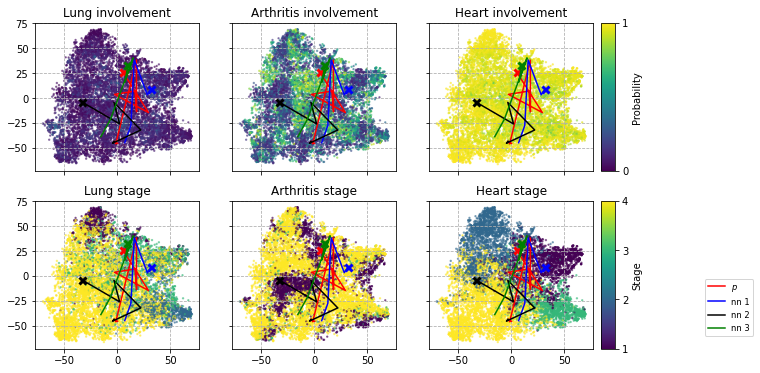

In [28]:
import matplotlib.cm as cm

titles = {
    0: "Lung involvement",
    4: "Arthritis involvement",
    2: "Heart involvement",
    1: "Lung stage",
    5: "Arthritis stage",
    3: "Heart stage",
}
fig, axs = plt.subplots(2, 3, figsize=(10, 6), sharex=True, sharey=True)

nn_colors = ["blue", "black", "green"]
for j, (label_index, title) in enumerate(titles.items()):
    row = j // 3  # Calculate the row index
    col = j % 3  # Calculate the column index
    ax = axs[row, col]
    indices = list_of_arrays_recon[label_index].all(axis=1)

    if title in ["Lung involvement", "Heart involvement", "Arthritis involvement"]:
        overlay_color = evaluation.res_list_y[label_index][1].detach()
        colorbar_vmin = 0
        colorbar_vmax = 1
        color = overlay_color[evaluation.indices_recon][indices]
        name_cbar = "Probability"
    else:
        overlay_color = evaluation.predicted_cats_y
        colorbar_vmin = np.nanmin(
            np.array(overlay_color[evaluation.indices_recon][:, label_index])
        )
        colorbar_vmax = np.nanmax(
            np.array(overlay_color[evaluation.indices_recon][:, label_index])
        )
        color = overlay_color[evaluation.indices_recon][:, label_index]
        name_cbar = "Stage"

    scatter = ax.scatter(
        z_tsne_test[:, 0],
        z_tsne_test[:, 1],
        c=color,
        alpha=0.5,
        vmin=colorbar_vmin,
        vmax=colorbar_vmax,
        s=2,
    )

    ax.plot(tsne_pat[:, 0], tsne_pat[:, 1], color="red", lw=1.5, label=f"$p$")
    ax.plot(
        tsne_pat[0, 0],
        tsne_pat[0, 1],
        marker="x",
        markersize=7,
        markeredgewidth=3,
        color="red",
    )
    for i_nn, ts in enumerate(nn_tsnes):
        ax.plot(
            ts[0, 0],
            ts[0, 1],
            marker="x",
            markersize=7,
            markeredgewidth=3,
            color=nn_colors[i_nn],
        )
        ax.plot(
            ts[:, 0], ts[:, 1], color=nn_colors[i_nn], lw=1.5, label=f"nn {i_nn + 1}"
        )

    ax.set_title(titles[label_index])
    ax.grid(linestyle="--")
    if (row == 1) & (col == 2):
        sm = cm.ScalarMappable(
            cmap=scatter.get_cmap(),
            norm=plt.Normalize(vmin=colorbar_vmin, vmax=colorbar_vmax),
        )
        sm.set_array([])  # Set an empty array to ensure correct color mapping
        cbar_ax = fig.add_axes(
            [
                axs[1, 2].get_position().x1 + 0.01,
                axs[1, 2].get_position().y0,
                0.02,
                axs[1, 2].get_position().height,
            ]
        )
        cbar_ax = fig.colorbar(
            sm, cax=cbar_ax, fraction=0.046, pad=0.04, ticks=[1, 2, 3, 4]
        )
        cbar_ax.ax.set_ylabel("Stage")
    if (row == 0) & (col == 2):
        sm = cm.ScalarMappable(
            cmap=scatter.get_cmap(),
            norm=plt.Normalize(vmin=colorbar_vmin, vmax=colorbar_vmax),
        )
        sm.set_array([])  # Set an empty array to ensure correct color mapping
        cbar_ax = fig.add_axes(
            [
                axs[0, 2].get_position().x1 + 0.01,
                axs[0, 2].get_position().y0,
                0.02,
                axs[0, 2].get_position().height,
            ]
        )
        cbar_ax = fig.colorbar(sm, cax=cbar_ax, fraction=0.046, pad=0.04, ticks=[0, 1])
        cbar_ax.ax.set_ylabel("Probability")
ax.legend(fontsize="small", bbox_to_anchor=(2, 0.5))

plt.show()